In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import minimize

mpl.rc('font', family = 'Gulim')
mpl.rcParams['axes.unicode_minus']=False

In [13]:
# load covid-19 data 
a = pd.read_csv("Project_week.csv", encoding = "euc-kr")

# total population
b = pd.read_csv("Projecti_population.csv", encoding = "euc-kr")

b = b.transpose()
b.columns = ["전국","서울","부산","대구","인천","광주","대전","울산","세종","경기","강원","충북","충남",
            "전북","전남","경북","경남","제주"]
b =b.iloc[1:]
b = b.astype(int)
b = (b/10000).astype(int)

b_des = b.describe()

population = b_des.iloc[5].astype(int)
population = population * 10000

# Korea

In [3]:
# Data abstract
a1 = a.iloc[:,[0,1,19]]

# Make S,E,I,R,D
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_9524\4273709318.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_9524\4273709318.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_9524\4273709318.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [4]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["전국"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

In [5]:
mu_lst = []
R0_lst = []

In [6]:
for i in range(7,56):
    data = a1.iloc[:i]
    # ODEs
    def model(y, t, beta, alpha, gamma, mu):
        S, E, I, R, D = y  
        dSdt = -beta * S * E
        dEdt = -alpha * E + beta * S * E  
        dIdt = alpha * E - gamma * I
        dRdt = gamma * (1 - mu) * I
        dDdt = gamma * mu * I
        return [dSdt, dEdt, dIdt, dRdt, dDdt]

    # Error function
    def loss(params, data, times):
        beta, alpha, gamma, mu = params
        y0 = data.iloc[0, 1:6].values
        ode_sol = odeint(model, y0, times, args=(beta, alpha, gamma, mu))
        diff = ode_sol[:, 2:5] - data.iloc[:, 3:6].values
        return np.sum(diff**2)

    # Time value
    times = data['week']

    # Initial parameter value
    initial_beta = 0.1
    initial_alpha = 0.1
    initial_gamma = 0.1
    initial_mu = 0.1
    initial_params = [initial_beta, initial_alpha, initial_gamma, initial_mu]

    # Optimization
    result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

    # Estimating parameter
    estimated_params = result.x
    print(i, "주차")
    print("Estimated Parameters:", estimated_params)
    # Parameter, R0
    beta, alpha, gamma, mu = estimated_params
    R0 = beta / gamma
    
    print("Estimated Basic Reproduction Number (R0):", R0)
    print("")
    mu_lst.append([i,mu])
    R0_lst.append([i,R0])

7 주차
Estimated Parameters: [ 5.28353614e-02  1.33390688e-05  2.15140369e-01 -1.72728911e-01]
Estimated Basic Reproduction Number (R0): 0.24558552953041637

8 주차
Estimated Parameters: [ 2.54236989e-01  1.73851114e-05  4.31494455e-01 -5.13533054e-02]
Estimated Basic Reproduction Number (R0): 0.5892010567246685

9 주차
Estimated Parameters: [ 1.34247121e-04  1.89601048e-05  5.11607506e-01 -5.72437777e-02]
Estimated Basic Reproduction Number (R0): 0.00026240256313185914

10 주차
Estimated Parameters: [ 5.40230117e-01  2.00680136e-05  6.04369095e-01 -1.14282093e-02]
Estimated Basic Reproduction Number (R0): 0.8938744906827156

11 주차
Estimated Parameters: [ 1.84865802e+00  2.03018755e-05  6.55073446e-01 -2.19350869e-03]
Estimated Basic Reproduction Number (R0): 2.822062214964487

12 주차
Estimated Parameters: [2.81749477e+00 2.01342318e-05 7.11433541e-01 4.48591346e-03]
Estimated Basic Reproduction Number (R0): 3.960306347454112

13 주차
Estimated Parameters: [2.93387462e+00 1.96659766e-05 7.6896451

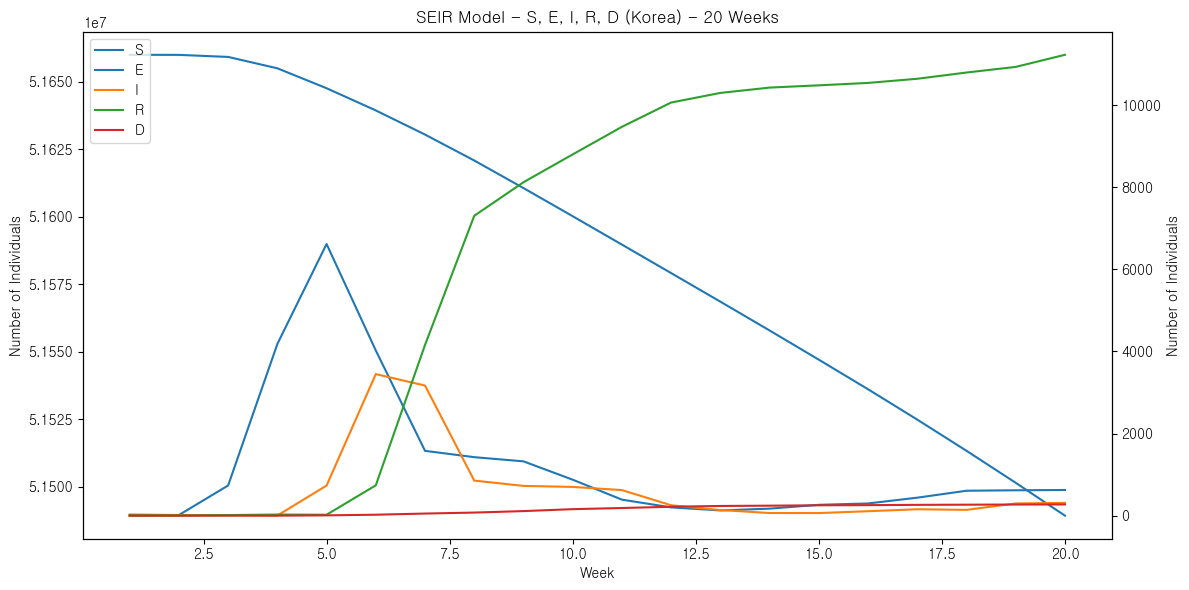

In [7]:
data = a1.iloc[:20]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Korea) - 20 Weeks')
ax1.set_xlabel('Week')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()

In [8]:
data

,week,S,E,I,R,D
0,1,51659973,24,3,0,0
1,2,51659944,15,11,3,0
2,3,51659182,735,13,14,0
3,4,51654971,4182,2,27,0
4,5,51647590,6619,733,22,7
5,6,51639362,4024,3449,739,23
6,7,51630425,1579,3170,4160,51
7,8,51620816,1425,854,7306,75
8,9,51610608,1323,725,8124,111
9,10,51600183,876,700,8802,158


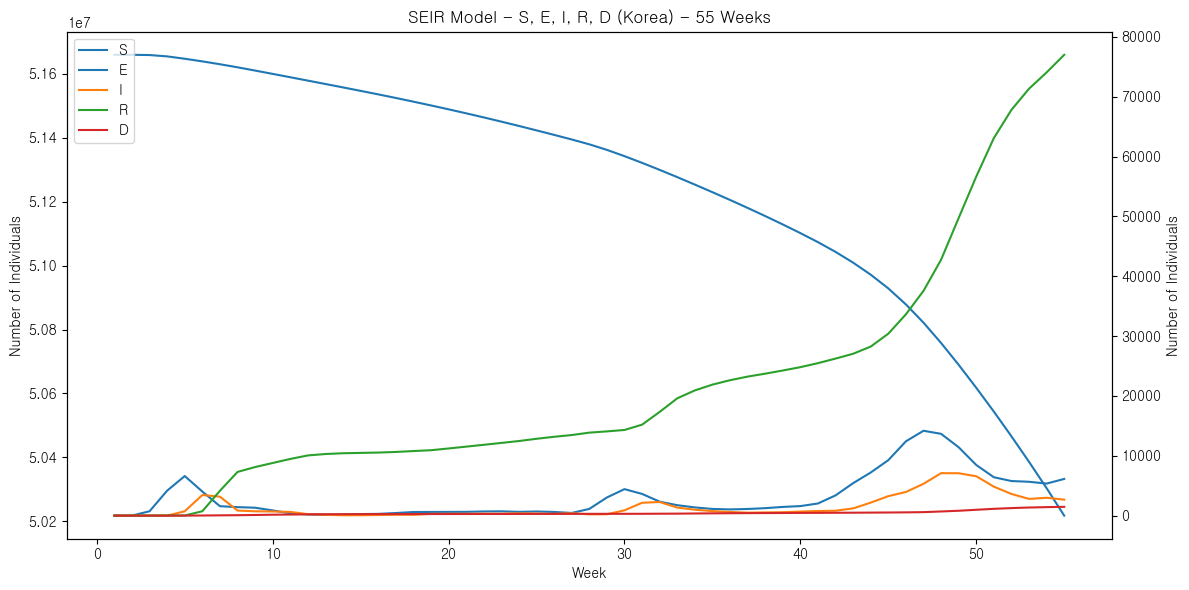

In [9]:
data = a1.iloc[:55]
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['week'], data['S'], label='S', linestyle='-')
ax1.set_ylabel('Number of Individuals')

ax2 = ax1.twinx() 
ax2.plot(data['week'], data['E'], label='E', linestyle='-')
ax2.plot(data['week'], data['I'], label='I', linestyle='-')
ax2.plot(data['week'], data['R'], label='R',linestyle='-')
ax2.plot(data['week'], data['D'], label='D',linestyle='-')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('SEIR Model - S, E, I, R, D (Korea) - 55 Weeks')

ax1.set_xlabel('Week')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent label overlapping
fig.tight_layout()

plt.show()